In [2]:
import pandas as pd
import random
# Define dataset path
lfw_dir = r"jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Name of the CSV files containing matching pairs and mismatching pairs
csv_path_match = r"jessicali9530/lfw-dataset/versions/4/matchpairsDevTrain.csv"
csv_path_mismatch = r"jessicali9530/lfw-dataset/versions/4/mismatchpairsDevTrain.csv"

# Create a dataframe for match and mismatch sets
df_match = pd.read_csv(csv_path_match)
df_mismatch = pd.read_csv(csv_path_mismatch)

# Change column type to string to store filepaths instead of numbers
df_match['imagenum1'] = df_match['imagenum1'].astype(str).str.zfill(4)
df_match['imagenum2'] = df_match['imagenum2'].astype(str).str.zfill(4)

df_mismatch['imagenum1'] = df_mismatch['imagenum1'].astype(str).str.zfill(4)
df_mismatch['imagenum2'] = df_mismatch['imagenum2'].astype(str).str.zfill(4)

# Replace imagenum1 and 2 values with the filepath to the desired files
df_match['image1'] = lfw_dir + "/" + df_match['name'] + "/" + df_match['name'] + "_" + df_match['imagenum1'] + ".jpg"
df_match['image2'] = lfw_dir + "/" + df_match['name'] + "/" + df_match['name'] + "_" + df_match['imagenum2'] + ".jpg"

df_mismatch['image1'] = lfw_dir + "/" + df_mismatch['name1'] + "/" + df_mismatch['name1'] + "_" + df_mismatch['imagenum1'] + ".jpg"
df_mismatch['image2'] = lfw_dir + "/" + df_mismatch['name2'] + "/" + df_mismatch['name2'] + "_" + df_mismatch['imagenum2'] + ".jpg"

# Mark all of the matching images as '1'
df_match['class'] = 1

# Mark all of the mismatching images as '0'
df_mismatch['class'] = 0

# Remove the unnecessary columns
df_match = df_match.drop(['name', 'imagenum1', 'imagenum2'], axis=1)
df_mismatch = df_mismatch.drop(['name1', 'imagenum1', 'imagenum2', 'name2'], axis=1)

# Concatenate the two dataframes
df_train = pd.concat([df_match, df_mismatch], axis=0, ignore_index=True).sample(frac=1).reset_index(drop=True)






In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision import models


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LFWDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load images
        img1 = cv2.imread(row["image1"])
        img2 = cv2.imread(row["image2"])

        # Convert BGR (cv2 default) to RGB
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        # Apply transforms (if any)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # Label (0 = mismatch, 1 = match)
        label = torch.tensor(row["class"], dtype=torch.float32)

        return img1, img2, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset instance
lfw_dataset = LFWDataset(df_train, transform=transform)

# Create DataLoader (shuffling for randomness)
train_loader = DataLoader(lfw_dataset, batch_size=32, shuffle=True)


#Define the model architecture
class FaceVerificationModel(nn.Module):
    def __init__(self,embedding_dim=128):
        super(FaceVerificationModel,self).__init__()

        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Freeze all layers in the backbone (ResNet50)
        for param in self.backbone.parameters():
            param.requires_grad = False

        for param in self.backbone.layer3.parameters():
            param.requires_grad = True

        for param in self.backbone.layer4.parameters():
            param.requires_grad = True

        self.backbone.fc = nn.Identity()

        self.fc_layers = nn.Sequential(

            nn.Linear(2048, 512),

            nn.ReLU(),

            nn.Linear(512, 256),

            nn.ReLU(),

            nn.Linear(256, embedding_dim)

        )

    def forward(self,x):
        features = self.backbone(x)
        embedding = self.fc_layers(features)
        return embedding

#Define the Loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin = 1.5):
        super(ContrastiveLoss,self).__init__()
        self.margin = margin

    def forward(self,emb1,emb2,y):
        distance = torch.norm(emb1 - emb2, p=2, dim=1)
        loss = 0.5 * (y * distance.pow(2) + (1 - y) * torch.clamp(self.margin - distance, min=0).pow(2))
        return loss.mean()



model = FaceVerificationModel().to(device)


learning_rate = 0.00005
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.005)



num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        # Forward pass
        emb1 = model(img1)
        emb2 = model(img2)

        # Compute contrastive loss
        loss = criterion(emb1, emb2, labels.squeeze())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training Complete!")

Epoch [1/7], Loss: 0.2178
Epoch [2/7], Loss: 0.0971
Epoch [3/7], Loss: 0.0539
Epoch [4/7], Loss: 0.0436
Epoch [5/7], Loss: 0.0382
Epoch [6/7], Loss: 0.0329
Epoch [7/7], Loss: 0.0301
Training Complete!


In [4]:
import pandas as pd

# Name of the CSV files containing matching pairs and mismatching pairs
csv_path_match_test = r"jessicali9530/lfw-dataset/versions/4/matchpairsDevTest.csv"
csv_path_mismatch_test = r"jessicali9530/lfw-dataset/versions/4/mismatchpairsDevTest.csv"

# Create a dataframe for match and mismatch sets
df_match_test = pd.read_csv(csv_path_match_test)
df_mismatch_test = pd.read_csv(csv_path_mismatch_test)

# Change column type to string to store filepaths instead of numbers
df_match_test['imagenum1'] = df_match_test['imagenum1'].astype(str).str.zfill(4)
df_match_test['imagenum2'] = df_match_test['imagenum2'].astype(str).str.zfill(4)

df_mismatch_test['imagenum1'] = df_mismatch_test['imagenum1'].astype(str).str.zfill(4)
df_mismatch_test['imagenum2'] = df_mismatch_test['imagenum2'].astype(str).str.zfill(4)

# Replace imagenum1 and 2 values with the filepath to the desired files
df_match_test['image1'] = lfw_dir + "/" + df_match_test['name'] + "/" + df_match_test['name'] + "_" + df_match_test['imagenum1'] + ".jpg"
df_match_test['image2'] = lfw_dir + "/" + df_match_test['name'] + "/" + df_match_test['name'] + "_" + df_match_test['imagenum2'] + ".jpg"

df_mismatch_test['image1'] = lfw_dir + "/" + df_mismatch_test['name1'] + "/" + df_mismatch_test['name1'] + "_" + df_mismatch_test['imagenum1'] + ".jpg"
df_mismatch_test['image2'] = lfw_dir + "/" + df_mismatch_test['name2'] + "/" + df_mismatch_test['name2'] + "_" + df_mismatch_test['imagenum2'] + ".jpg"

# Mark all of the matching images as '1'
df_match_test['class'] = 1

# Mark all of the mismatching images as '0'
df_mismatch_test['class'] = 0

# Remove the unnecessary columns
df_match_test = df_match_test.drop(['name', 'imagenum1', 'imagenum2'], axis=1)
df_mismatch_test = df_mismatch_test.drop(['name1', 'imagenum1', 'imagenum2', 'name2'], axis=1)

# Concatenate the two dataframes
df_test = pd.concat([df_match_test, df_mismatch_test], axis=0, ignore_index=True).sample(frac=1).reset_index(drop=True)






In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Create test dataset and dataloader
lfw_test_dataset = LFWDataset(df_test, transform=transform)
test_loader = DataLoader(lfw_test_dataset, batch_size=32, shuffle=False)

# Function to evaluate the model
def evaluate(model, test_loader, threshold=0.77, device="cuda"):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient tracking needed
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Get embeddings
            emb1 = model(img1)
            emb2 = model(img2)

            # Compute Euclidean distance
            distances = torch.norm(emb1 - emb2, p=2, dim=1)

            # Predict class: if distance < threshold → same person (1), else → different (0)
            predictions = (distances < threshold).float()

            # Compute accuracy
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Move model to device and evaluate
evaluate(model, test_loader, device=device)


Test Accuracy: 80.80%


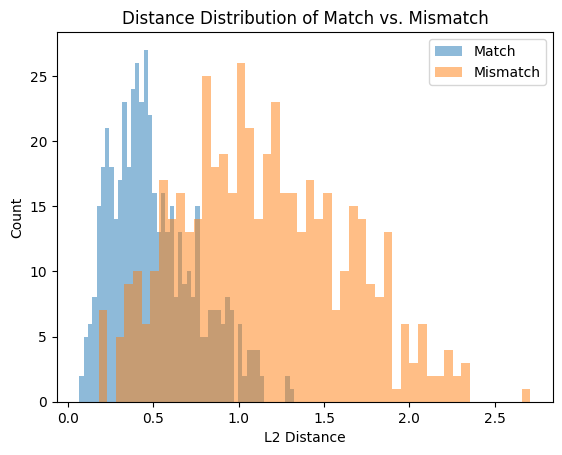

In [ ]:
#Plot the graph of L2 distance between test pairs VS number of test pairs
import matplotlib.pyplot as plt

distances = []
labels = []

model.eval()
with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2 = img1.to(device), img2.to(device)
        emb1 = model(img1)
        emb2 = model(img2)
        dist = torch.norm(emb1 - emb2, p=2, dim=1).cpu().numpy()

        distances.extend(dist)
        labels.extend(label.numpy())

plt.hist([distances[i] for i in range(len(labels)) if labels[i] == 1], bins=50, alpha=0.5, label="Match")
plt.hist([distances[i] for i in range(len(labels)) if labels[i] == 0], bins=50, alpha=0.5, label="Mismatch")
plt.xlabel("L2 Distance")
plt.ylabel("Count")
plt.legend()
plt.title("Distance Distribution of Match vs. Mismatch")
plt.show()